---
<div align="center">

# Lung Cancer Classification with

CT [Computerized Tomography] Data
-
</div>

---

---
## Index
---

> INSERT PROJECT INDEX HERE

---
## Problem Formulation
---

### Context

Lung cancer remains the leading cause of cancer-related mortality worldwide. Unfortunately, only 16% of cases are diagnosed at an early, localized stage, where patients have a five-year survival rate exceeding 50%. When lung cancer is identified at more advanced stages, the survival rate plummets to just 5%.

Given this stark difference, early diagnosis is critical for improving patient outcomes. Non-invasive imaging methods, such as computed tomography (CT), have proven effective in providing crucial information regarding tumor status. This opens opportunities for developing computer-aided diagnosis (CAD) systems capable of assessing the malignancy risk of lung nodules and supporting clinical decision-making.

### Resolution Approach

Due to factors like high inter-observer variability in visual assessments and the large volumes of radiological data to be analyzed, developing fully automated diagnostic systems is increasingly appealing.

The goal of this project is to create a machine learning-based solution for classifying lung nodules as benign or malignant using CT images. The publicly available LIDC-IDRI dataset, containing expertly annotated CT scans of the human torso, will serve as the primary data source. By employing advanced feature extraction techniques (e.g., radiomics) and modern machine learning algorithms, the aim is to accurately predict the malignancy of detected nodules.

### Planned Work

The project will involve several key steps, including:

- ``Data Preprocessing`` : Cleaning and preparing the CT scan data to ensure its quality and consistency for further analysis.
- ``Feature Engineering`` : Leveraging radiomics and deep learning techniques to extract meaningful features from the scans.
- ``Model Development`` : Training and fine-tuning machine learning models to accurately classify lung nodules based on their malignancy status.
- ``Performance Evaluation`` : Assessing model performance using key metrics such as accuracy and AUC, and validating results through robust methods such as k-fold cross-validation.
  
The ultimate objective of this automated classification system is to aid in clinical decision-making, offering a supplementary screening tool that reduces the workload on radiologists while improving early detection rates for lung cancer.

---
## Project Dependencies
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import os
from pprint import (pprint)
import radiomics
from radiomics import (featureextractor)
import customPylidc as pl
from customPylidc import (ClusterError)
from FeatureExtraction import (extractPyradiomicsFeatures)
from Utils.DataVisualization import (plot_feature_distribution)

---
## Data Preprocessing
---

This section focuses on the extraction, analysis, and cleaning of the CT scan data from the LIDC-IDRI dataset, making use of the pylidc and pyradiomics libraries.

### LIDC-IDRI Dataset

The LIDC-IDRI is a lung cancer screening dataset which comprises thoracic CT scans for a total of 1010 patients, alongside annotated nodules belonging to one of three classes: 

<table>
  <tr>
    <th colspan="2">Nodules Classification</th>
  </tr>
  <tr>
    <th>Class Label</th>
    <th>Diameter</th>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ < \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Non-Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
</table>

These annotations were performed through a two-phase process by four experienced radiologists. In addition to the CT images, the dataset provides annotations on malignancy, nodule/non-nodule locations, and clinical information about the patients.

This dataset contains a standardized DICOM representation of the annotations and characterizations gathered by the LIDC/IDRI initiative, which were originally stored in XML format. Only nodules with a largest planar dimension of 3 mm or greater have been annotated and characterized by expert radiologists, and only these nodules are included in the current dataset.

The conversion was facilitated by the pylidc library, which handles XML parsing, volumetric reconstruction of the nodule annotations, clustering of annotations for the same nodule, and the calculation of nodule volume, surface area, and largest diameter.

---
### Initial Data Analysis
---

In this initial phase, we will focus on analyzing the data available in the pylidc package to gain deeper insights into how we can utilize this information to later detect nodule malignancy using machine learning algorithms.

After thoroughly reviewing the pylidc package documentation, we discovered that each patient is associated with a Scan, which may include multiple nodule annotations from different doctors who aimed to accurately identify the malignancy stage of the nodules within each CT Scan.

---
#### Population Dimensions
---

We decided to begin by analyzing the characteristics of the population, specifically focusing on the number of patients, scans and annotations.

In [4]:
# Checking the amount of patients available
print(f"There are {np.unique(np.array([scan.patient_id for scan in pl.query(pl.Scan).all()])).size} Total Patients")

There are 1010 Total Patients


In [5]:
# Checking the amount of scans available
print(f"There are {len(pl.query(pl.Scan).all())} Scans available")

There are 1018 Scans available


In [6]:
# Checking the amount of Annotations available
print(f"There are {len(pl.query(pl.Annotation).all())} Annotation available")

There are 6859 Annotation available


In [7]:
# Getting all the patient IDs
patientIds = sorted(np.unique([patient[0] for patient in pl.query(pl.Scan.patient_id).all()]))

# Calculate the amount of scans per patient
numberScansPerPatient = [len(pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).all()) for pid in patientIds]

# Calculate the range value of Scans per all the Patients
uniqueScansPerPatient = np.unique(numberScansPerPatient)
print(f"The dataset contains patients with:")
[print(f"-> {uniqueScans} Scan(s)") for uniqueScans in uniqueScansPerPatient];

The dataset contains patients with:
-> 1 Scan(s)
-> 2 Scan(s)


In [8]:
# Get the patient ids with 1 Scan
idsPatientsOneScan = [idx + 1 for (idx, numberScans) in enumerate(numberScansPerPatient) if numberScans == 1]
print(f"The dataset contains {len(idsPatientsOneScan)} / {len(patientIds)} patinets with 1 Scan")

# Get the patient ids with more than 1 Scan
idsPatientsTwoScans = [idx + 1 for (idx, numberScans) in enumerate(numberScansPerPatient) if numberScans > 1]
print(f"The dataset contains {len(idsPatientsTwoScans)} / {len(patientIds)} patinets with 2 Scans")

The dataset contains 1002 / 1010 patinets with 1 Scan
The dataset contains 8 / 1010 patinets with 2 Scans


---
#### [LIDC-IDRI-0001] Patient Nodule Visualization
---

Then, we wanted to visualize how the first patient nodule's data looked like.

In [9]:
# Choose a patient ID
pid = 'LIDC-IDRI-0009'

# Fetch the patient's scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Get the Patient Nodules Annotations
patientNodules = scan.cluster_annotations()
print(f"The Patient {pid}'s Scan has {len(patientNodules)} Nodule(s)")
# print(f"The Patient {pid}'s Scan ID {scan.id} has {len(patientNodules)} Nodule(s)")

# Get the Scan's first annotation
ann = scan.annotations[0]

The Patient LIDC-IDRI-0009's Scan has 2 Nodule(s)


In [10]:
# Cluster the Annotations to the Patient Nodules
nods = scan.cluster_annotations()

# Print the Number of Nodules the patient has
print("%s has %d nodule(s)." % (scan.patient_id, len(nods)))

# Print the number of annotations for each one of the patient's nodules
for i, nod in enumerate(nods):
    print("Nodule %d has %d annotation(s)." % (i+1, len(nods[i])))

LIDC-IDRI-0009 has 2 nodule(s).
Nodule 1 has 1 annotation(s).
Nodule 2 has 1 annotation(s).


Loading dicom files ... This may take a moment.


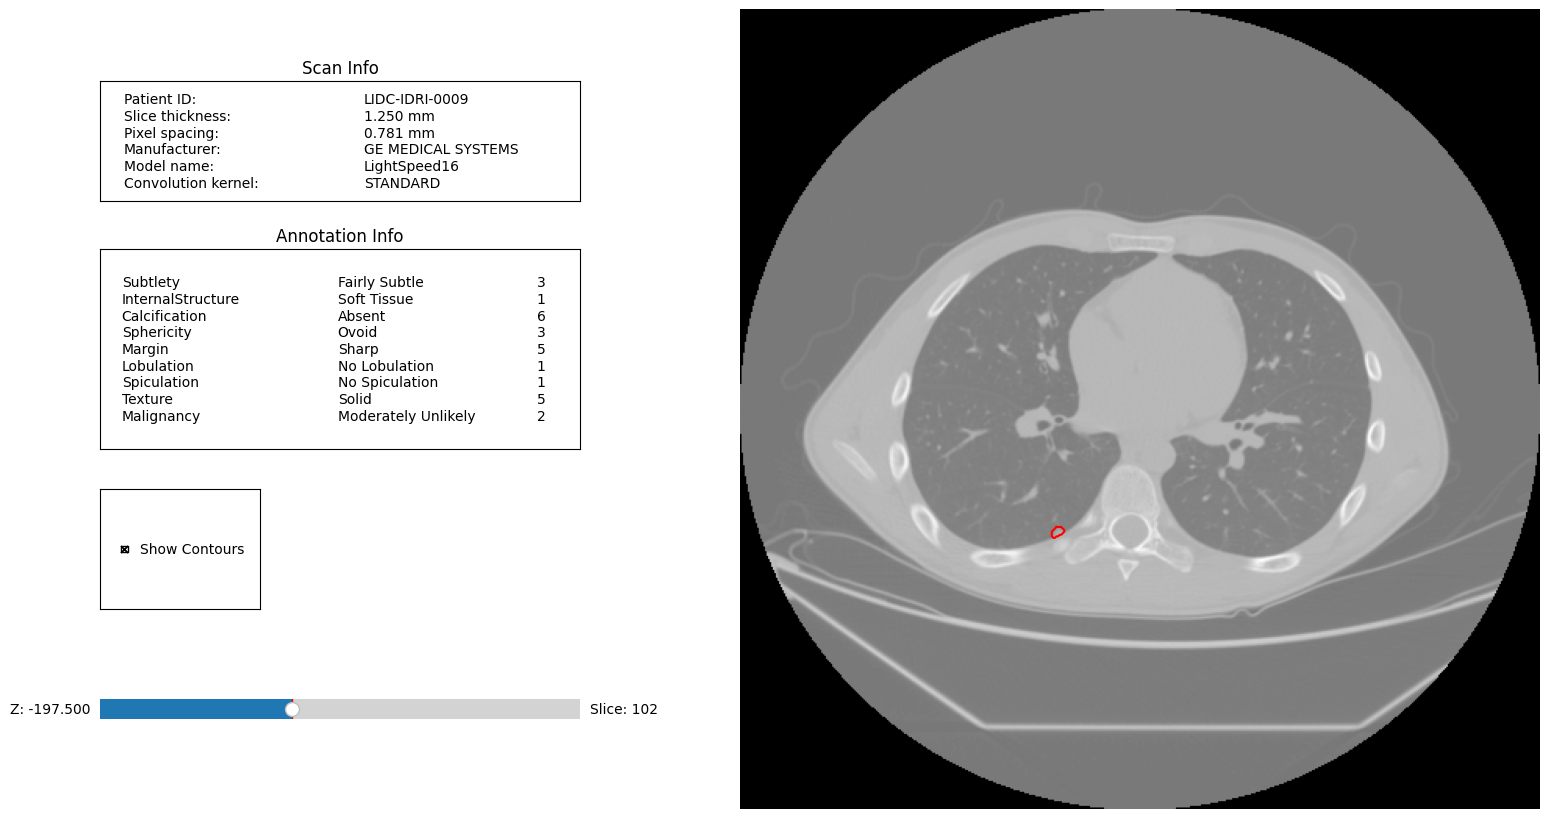

In [11]:
# Visualize the CT Scan
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


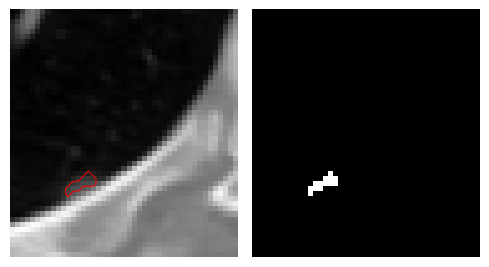

In [12]:
# Plot the Nodule's Mask
ann.visualize_nodule_mask()

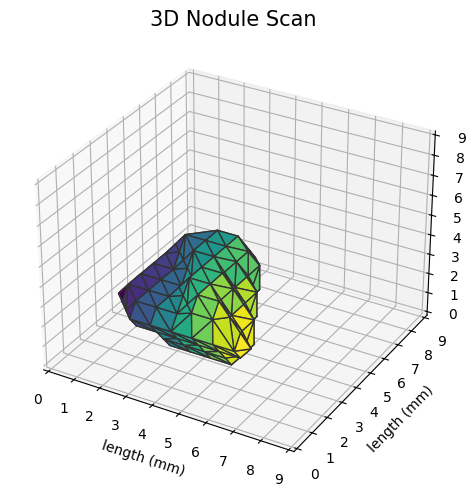

In [13]:
# Plot the Nodule 3D Scan
ann.visualize_in_3d()

---
### [PyLIDC] Features Dataset
---

> The package contains the semantical features

> ADD A DESCRIPTION OF THE PACKAGE [ITS CONTENTS] AND WHAT IT ENABLED US TO DO

---
#### [PyLIDC] Feature Extraction
---

After reviewing and reconsidering the Nodule Attributes in the [Pylidc package documentation](https://pylidc.github.io/) (as also summarized in the [README.md](./customPylidc/README.md) file within our customPylidc package), we selected those which we believe could contribute most significantly to predicting nodule malignancy. Consequently, we created a simple framework for dataset creation, which will be populated by querying the data from the aforementioned package.

In [14]:
# Define a name for the file to store the pylidc features
pylidcFeaturesFilename = './Datasets/pylidc_features.csv'

In [15]:
def createPylidcInitialDataframe():
    # Define the initial structure of the Dataframe
    df = pd.DataFrame(columns=['nodule_id',           # Nodule Identification Number [Form “LIDC-IDRI-dddd-ii” where dddd is a string of integers and ii is the identifier of the patient's nodule 
                               'slice_thickness',     # DICOM attribute (0018,0050)
                               'pixel_spacing',       # Dicom attribute (0028,0030)
                               'slice_spacing',       # Space between slices
                               'subtlety',            # Difficulty of detection
                               'internalStructure',   # Internal composition of the nodule
                               'calcification',       # Pattern of calcification
                               'sphericity',          # Three-dimensional shape of the nodule 
                               'margin',              # How well-defined the nodule margin is
                               'lobulation',          # Degree of lobulation
                               'spiculation',         # Extent of spiculation present
                               'texture',             # Radiographic solidity - internal texture
                               'diameter',            # Maximal diameter
                               'surface_area',        # Estimated surface area
                               'volume',              # Estimated 3D volume of the annotated nodule
                               'malignancy',          # likelihood of malignancy -> Target [What we want to predict]
                             ])
    return df

In [16]:
def extractPylidcFeatures(pylidcFeaturesFilename:str) -> pd.DataFrame:
    """
    # Description
        -> This function aims to extract the important features from the CT data scans through the Pylidc package.
           It will find the mode / mean values for each nodule's annotations throughout all the available patients.

    := param: pylidcFeaturesFilename - Path to save the final dataset to
    := return: df - Dataframe with the propely formated results
    """
    # Initialize the dataframe
    df = createPylidcInitialDataframe()
    
    # Fetch all the Patient Ids Available
    patientIds = sorted(np.unique([scan.patient_id for scan in pl.query(pl.Scan).all()]))

    # Creating a list to store all the patient's whose nodule's clustering failed
    failedClusterAnalysis = []
    
    # Iterate over all the patient Ids
    for patientId in patientIds:
        # Get all the Scans associated with the current patient
        patientScan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patientId).first()
        
        try:
            # Debug: print scan ID and basic info
            print(f"Processing scan {patientScan.patient_id}")
            
            # Fetch the nodes associated with each patient Scan
            patientNodules = patientScan.cluster_annotations(tol=2.0)

        except ClusterError:
            print(f"ClusterError for patient {patientId}, scan {patientScan.patient_id}. Adjusting tolerance.")
            failedClusterAnalysis.append(patientId)
            continue
           
        # Iterate over the patient nodules
        for noduleId, nodule in enumerate(patientNodules):
            # Define a dictionary with the important features as keys and list with the current nodule
            allAttributes = dict([(col, []) for col in df.columns[1:]])
        
            # Initialize a dictionary with the df's attributes / columns and empty strings
            attributes  = dict((col, "") for col in df.columns)
            
            # Iterate over the nodule annotations and save the important attributes inside the allAttributes dictionary
            for annotation in nodule:
                for noduleAttribute in df.columns[1:]:
                    if hasattr(patientScan, noduleAttribute):
                        allAttributes[noduleAttribute] += [getattr(patientScan, noduleAttribute)]
                    elif hasattr(annotation, noduleAttribute):
                        allAttributes[noduleAttribute] += [getattr(annotation, noduleAttribute)]
                    else:
                        print(f"The attribute '{noduleAttribute}' does not exist in Annotation nor Scan classes.")

            # Add an ID for the patient nodule
            attributes['nodule_id'] = f"{patientId}-{noduleId + 1}"
            
            # Normalizing the collected data
            for noduleAttribute in df.columns[1:]:
                if isinstance(allAttributes[noduleAttribute][0], float):
                    attributes[noduleAttribute] = np.mean(allAttributes[noduleAttribute])
                elif isinstance(allAttributes[noduleAttribute][0], int):
                    attributes[noduleAttribute] = stats.mode(allAttributes[noduleAttribute])
                else:
                    attributes[noduleAttribute] = stats.mode(allAttributes[noduleAttribute])
            
            # Convert the new row into a Dataframe and add it to the previous one
            df_new_nodule = pd.DataFrame.from_dict([attributes])
            df = pd.concat([df, df_new_nodule], ignore_index=True)

    # Sort the dataframe based on the patient ID feature
    df = df.sort_values(by=['nodule_id'], ascending=[True])
    
    # Save the results into a .csv file
    df.to_csv(pylidcFeaturesFilename, sep=',', index=False)

    # Print failed processes
    print(f"\nFailed analysing the nodules from {len(failedClusterAnalysis)} patients.")
    
    # Return the Final dataframe
    return df 

In [17]:
# Define a name for the file to store the pylidc features
pylidcFeaturesFilename = './Datasets/pylidc_features.csv'

# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(f'./{pylidcFeaturesFilename}'):
    df_pylidc = extractPylidcFeatures(pylidcFeaturesFilename)
else:
    df_pylidc = pd.read_csv(f'./{pylidcFeaturesFilename}')

In [18]:
# Get some information regarding the dataset
df_pylidc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nodule_id          2617 non-null   object 
 1   slice_thickness    2617 non-null   float64
 2   pixel_spacing      2617 non-null   float64
 3   slice_spacing      2617 non-null   float64
 4   subtlety           2617 non-null   int64  
 5   internalStructure  2617 non-null   int64  
 6   calcification      2617 non-null   int64  
 7   sphericity         2617 non-null   int64  
 8   margin             2617 non-null   int64  
 9   lobulation         2617 non-null   int64  
 10  spiculation        2617 non-null   int64  
 11  texture            2617 non-null   int64  
 12  diameter           2617 non-null   float64
 13  surface_area       2617 non-null   float64
 14  volume             2617 non-null   float64
 15  malignancy         2617 non-null   int64  
dtypes: float64(6), int64(9),

In [19]:
# Check the dataframe dimensions
(rows, cols) = df_pylidc.shape
print(f"The pylidc feature dataset contains {rows} rows and {cols} cols")

The pylidc feature dataset contains 2617 rows and 16 cols


In [20]:
# Inspect the new dataset
df_pylidc.head()

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,diameter,surface_area,volume,malignancy
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,5,5,32.755812,2491.466573,6989.673615,5
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,1,1,30.781671,2807.198994,7244.667508,5
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,5,1,6,4,3,2,2,4,31.134465,2179.792304,6161.853145,5
3,LIDC-IDRI-0003-2,2.50,0.820312,2.50,4,1,6,3,4,1,1,5,13.309155,321.183599,472.089669,4
4,LIDC-IDRI-0003-3,2.50,0.820312,2.50,4,1,6,4,5,1,1,5,14.983128,641.243433,1313.229390,4


---
#### [PyLIDC] Feature Cleaning and Analysis
---

In this subsection, we aim to conduct an exploratory data analysis along with thorough data cleaning on the PyLIDC dataset, which will allow us to effectively prepare this data for the machine learning algorithms we plan to use to address the problem.

We began by analyzing the distribution of the malignancy feature [Target Class] within the dataset population.

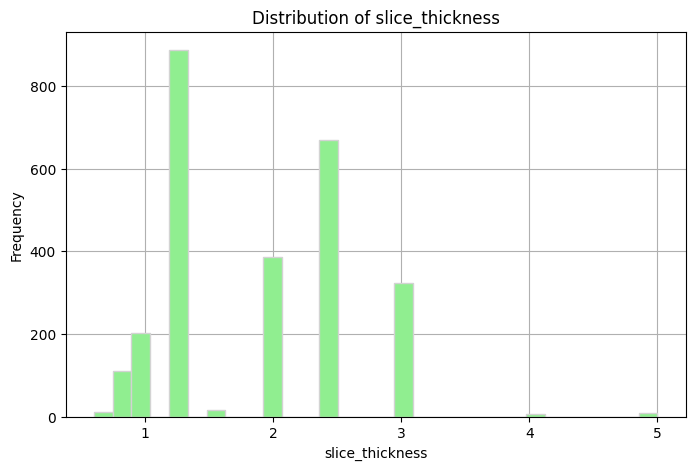

In [21]:
plot_feature_distribution(df_pylidc, 'slice_thickness', False)

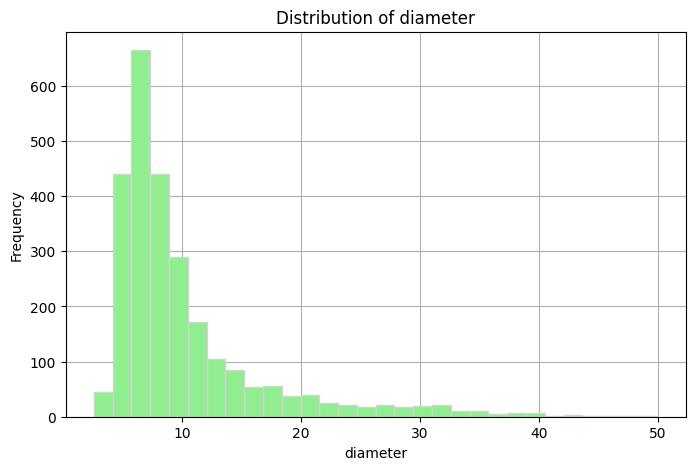

In [22]:
# Plot the diameter distribution from the nodules population
plot_feature_distribution(df_pylidc, 'diameter', False)

In [23]:
# Define a target label decoder
malignancyDecoder = {
    1:'Highly Unlikely',
    2:'Moderately Unlikely',
    3:'Indeterminate',
    4:'Moderately Suspicious',
    5:'Highly Suspicious'
}

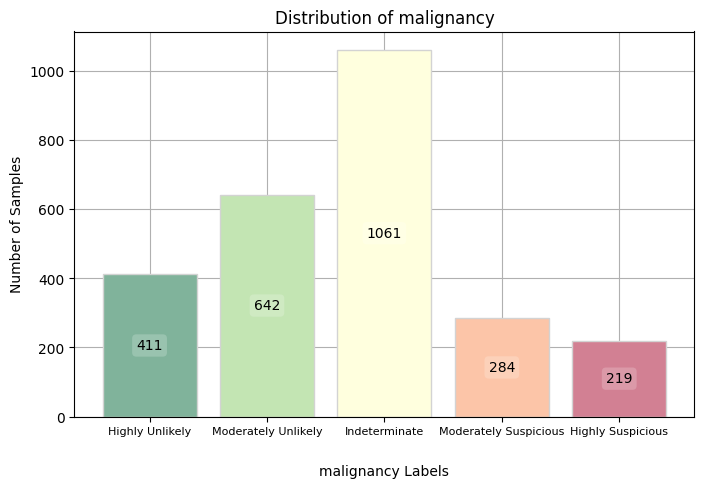

In [24]:
# Plot Malignancy class distribution
plot_feature_distribution(df_pylidc, 'malignancy', True, malignancyDecoder)

As we can observe from the Distribution of Malignancy on the Population there are two main important aspects:

<td>&nbsp;&nbsp;&rightarrow; Target Class Distribution
    <dd>Most nodule's annotations seem to be indeterminate which does not improve the information used in the model's development. Therefore, we considered removing all the respective entries.</dd>
</td>
<td>&nbsp;&nbsp;&rightarrow; Multi-Class Classification
    <dd>Due to the complexity inherent to a multi-class classification problem, we aim to adapt it into a binary classification problem.</dd>
</td>

#### Target Class Distribution

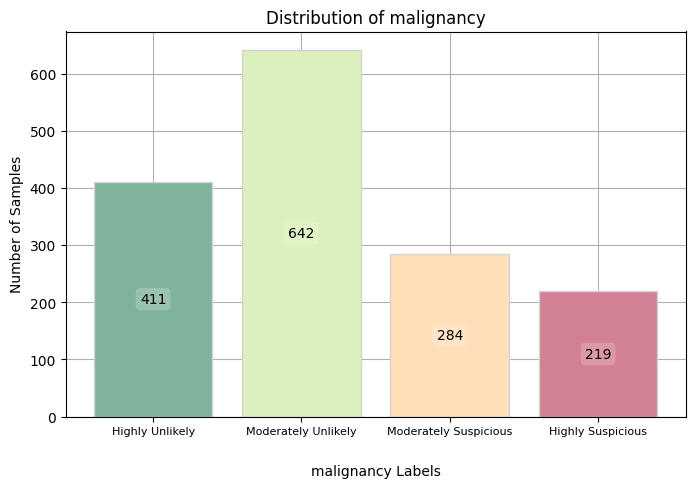

In [25]:
# Remove neutral cases from the dataset
df_pylidc = df_pylidc.loc[df_pylidc['malignancy'] != 3]

# Plot the updated target feature distribution
plot_feature_distribution(df_pylidc, 'malignancy', True, malignancyDecoder)

#### Target Label Binarization

In [26]:
# Create a target decoder to visualize the binary target labels
targetDecoder = {
    0:'Highly Unlikely',
    1:'Highly Suspicious'
}

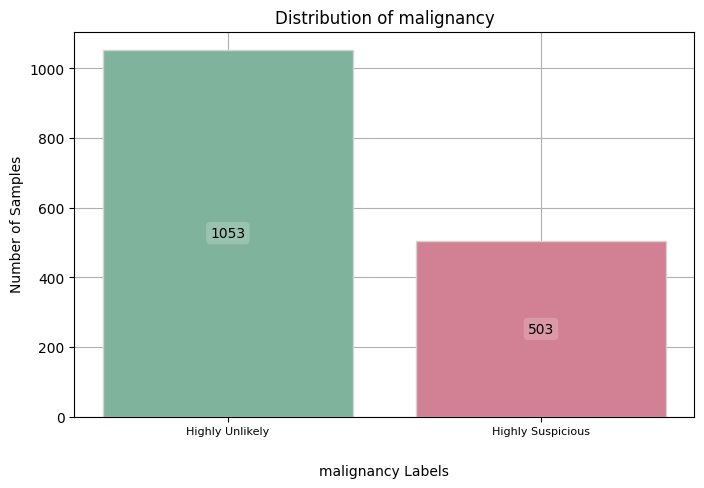

In [27]:
# Perform Binarization
df_pylidc['malignancy'] = df_pylidc['malignancy'].apply(lambda x: 0 if x <= 2 else 1)

# Plot the updated target feature distribution
plot_feature_distribution(df_pylidc, 'malignancy', True, targetDecoder)

---
## Feature Engineering
---

> WHAT DOES FEATURE ENGINEERING INTENDED TO ADD TO THE PROJECT AND HOW
> EXTRACT ADDITIONAL IMPORTANT FEATURES FROM THE PYRADIOMICS LIBRARY

---
### Pyradiomics Features Dataset
---

> Describe the whole process to obtain a dataset with the pyradiomics features

> Describe the extraction setup and what we aim to gain from it. What was used (Packages, other resources, ....)
> Perform the extraction with the images and merge the results with the previous dataset
> Clean the Data and save it

---
#### [Pyradiomics] Feature Extraction
---

In [28]:
# Defining the path to the pyradiomics features dataset
pyradiomicsFeaturesFilename = './Datasets/pyradiomics_features.csv'

# Variable to determine if we perform feature extration using the pyradiomics package
extractPyradiomicsFeatures = False

# Perform Pyradiomics Feature Extraction
if extractPyradiomicsFeatures:
    files_path = 'c:\\Insert\\Global\\Path\\To\\LIDC-IDRI'
    extractPyradiomicsFeatures(Lidc_IdrFilesPath=files_path,
                               pyradiomicsDcmScriptPath='./pyradiomics-dcm.py',
                               pyradiomicsParamsFilePath='./Pyradiomics_Params.yaml',
                               pyradiomicsFeatureDictFilePath='./featuresDict.tsv',
                               startPatient=0,
                               outputDirectoryPath='./OutputSR',
                               tempDirectoryPath='./TempDir')
# Load the dataset
else:
    df_pyradiomics = pd.read_csv(pyradiomicsFeaturesFilename, index_col=False)

In [29]:
# Get some information regarding the dataset
df_pyradiomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Columns: 1599 entries, annotation_id to logarithm_ngtdm_Strength
dtypes: float64(1565), int64(4), object(30)
memory usage: 57.2+ MB


In [30]:
# Check the dataframe dimensions
(rows, cols) = df_pyradiomics.shape
print(f"The pyradiomics feature dataset contains {rows} rows and {cols} cols")

The pyradiomics feature dataset contains 4688 rows and 1599 cols


In [31]:
# Inspect the first rows from the dataset
df_pyradiomics.head(3)

,annotation_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214


In [32]:
# Split the 'annotation_id' column into 'patient_id' and 'nodule_id'
df_pyradiomics[['patient_id', 'ann_id']] = df_pyradiomics['annotation_id'].str.rsplit('-', n=1, expand=True)

# Reorder the columns to move 'patient_id' and 'nodule_id' to the beginning
cols = ['patient_id', 'ann_id'] + [col for col in df_pyradiomics.columns if col not in ['patient_id', 'ann_id']]

# Drop 'annotation_id' and reorder the DataFrame
df_pyradiomics = df_pyradiomics[cols]

# Remove the annotation id column
df_pyradiomics = df_pyradiomics.drop(columns=['annotation_id'], axis=1)

In [33]:
df_pyradiomics.iloc[:, 143:] = df_pyradiomics.iloc[:, 143:].apply(lambda x: x.shift(273) if x.isna().any() else x, axis=1)

# Drop rows with NaN Values
df_pyradiomics = df_pyradiomics.dropna(how='any')

df_pyradiomics.head(3)

,patient_id,ann_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001,2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001,3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214


In [34]:
def refactorPyradiomicsDataset(df_pyradiomics:pd.DataFrame, pyradiomicsRefactoredFeaturesFilename:str, verbose:bool=False) -> pd.DataFrame:
    """
    # Description
        -> This function aims to refactor the pyradiomics dataset so that we take into
        consideration the mode / average values for all the nodules features parting
        from the annotations of the nodules provided by the pyradiomics_feature dataset

    := param: df_pyradiomics - Extracted dataframe with the raw information
    := param: pyradiomicsFeaturesFilename - Path to save the refactored version of the dataset
    := param: verbose - Boolean that enables valuable information during the function execution (reagarding the data being dealt with)
    := return: Pandas dataframe with a refactored version of the pyradiomics dataframe
    """
    # Define the columns for the refactored pyradiomics dataset
    cols = ['nodule_id'] + list(df_pyradiomics.columns)

    # Create a new empty dataframe for the refactored dataset
    df = pd.DataFrame(columns=cols)

    # Fetch all the Patient Ids Available
    patientIds = sorted(np.unique([scan.patient_id for scan in pl.query(pl.Scan).all()]))

    # Iterate over all the patient Ids
    for patientId in patientIds:
        if verbose:
            print(f"\n-> [NEW PATIENT: {patientId}]\n")
        
        # Fetch the patient's scan
        patientScan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patientId).first()

        # Creating a mask to filter the current patient data from the pyradiomics dataframe
        mask = df_pyradiomics[df_pyradiomics.columns[0]].str.contains(patientId)
        
        # Get the segment of the dataframe with the current patient
        pyradiomicsPatientDf = df_pyradiomics.loc[mask]

        if pyradiomicsPatientDf.shape[0] == 0:
            print(f"Patient {patientId} not found inside the Pyradiomics extracted dataset!")
            continue
        
        if verbose:
            print(f"Patient dataframe shape: {pyradiomicsPatientDf.shape}")
        
        # Get the Patient Nodules Annotations
        patientNodules = patientScan.cluster_annotations()

        if verbose:
            print(f"Number of nodules: {len(patientNodules)}")
        
        # Iterate over the patient nodules
        for noduleId, nodule in enumerate(patientNodules):
            if verbose:
                print(f"[NEW NODULE: {noduleId + 1}]")
                print(f"Number of annotations: {len(nodule)}")
            
            # Check that the nodule list is not empty
            if len(nodule) == 0:
                print(f"Skipping empty nodule: {noduleId}")
                continue
            
            # Define a dictionary with the important features as keys and list with the current nodule
            allAttributes = dict([(col, []) for col in df.columns[1:]])
        
            # Initialize a dictionary with the df's attributes / columns and empty strings
            attributes = dict((col, "") for col in df.columns)
            
            # Iterate over the nodule annotations and save the important attributes inside the allAttributes dictionary
            for currentAnnotation in range(len(nodule)):
                if verbose:
                    print(f"[NEW ANNOTATION: {currentAnnotation + 1}]")
                
                # Check if the number of annotations matches
                if currentAnnotation >= pyradiomicsPatientDf.shape[0]:
                    print(f"Skipping invalid annotation at index {currentAnnotation}")
                    continue
                
                for noduleAttribute in df.columns[1:]:
                    try:
                        allAttributes[noduleAttribute] += [pyradiomicsPatientDf[noduleAttribute].values[currentAnnotation]]
                    except KeyError:
                        print(f"Skipping unknown attribute: {noduleAttribute}")
                        continue

            # Add an ID for the patient nodule
            attributes['nodule_id'] = f"{patientId}-{noduleId + 1}"
            
            # Normalizing the collected data
            for noduleAttribute in df.columns[1:]:
                # print(allAttributes[noduleAttribute])
                if isinstance(allAttributes[noduleAttribute][0], float):
                    attributes[noduleAttribute] = np.mean(allAttributes[noduleAttribute])
                elif isinstance(allAttributes[noduleAttribute][0], int):
                    attributes[noduleAttribute] = stats.mode(allAttributes[noduleAttribute])
                else:
                    attributes[noduleAttribute] = allAttributes[noduleAttribute][0]
            
            # Convert the new row into a Dataframe, reset index, and add it to the main dataframe
            df_new_nodule = pd.DataFrame.from_dict([attributes])
            
            # Concatenate ensuring index consistency
            if verbose:
                print(f"Before concat: df shape: {df.shape}, new nodule shape: {df_new_nodule.shape}")
            
            df = pd.concat([df, df_new_nodule], ignore_index=True)

            if verbose:
                print(f"After concat: df shape: {df.shape}")
    
    # Sort the dataframe based on the patient ID feature
    df = df.sort_values(by=['nodule_id'], ascending=[True]).reset_index(drop=True)
    
    # Save the results into a .csv file
    df.to_csv(pyradiomicsRefactoredFeaturesFilename, sep=',', index=False)

    return df

In [35]:
# Define a path for the Refactored version of the pyradiomics dataset
pyradiomicsRefactoredFeaturesFilename = './Datasets/refactored_pyradiomics_features.csv'

# Check if is has already been created
if not os.path.exists(pyradiomicsRefactoredFeaturesFilename):
    df_refactored_pyradiomics = refactorPyradiomicsDataset(df_pyradiomics, pyradiomicsRefactoredFeaturesFilename, verbose=False)

# Load the refactored dataset
else:
     df_refactored_pyradiomics = pd.read_csv(pyradiomicsRefactoredFeaturesFilename, index_col=False)

In [36]:
# Inspect the new refactored dataframe
df_refactored_pyradiomics.head(3)

,nodule_id,patient_id,ann_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,LIDC-IDRI-0001,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,0.125483,0.020089,0.454728,708.128969,0.009230,0.123915,0.002229,35948.350251,6.665276,14.423402
1,LIDC-IDRI-0002-1,LIDC-IDRI-0002,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,104.713631,0.517346,0.083483,76.432466,0.012528,1.814987,0.007012,1896.840261,0.618637,52.197389
2,LIDC-IDRI-0003-1,LIDC-IDRI-0003,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,209.395329,0.693513,0.032239,1.005262,0.008692,13.673589,0.009964,15.072607,0.017851,4.623489


---
#### [Pyradiomics] Feature Cleaning and Processing
---

In [37]:
# np.unique(df_pyradiomics['diagnostics_Image-original_Dimensionality'])

In [38]:
# Get the dtypes from the features
colsTypes = np.unique(list(df_refactored_pyradiomics.dtypes))
print(f"The pyradiomics dataset is composed of features with the following dtypes: \n")
[print(f"-> {col}") for col in colsTypes]
print()

The pyradiomics dataset is composed of features with the following dtypes: 

-> int64
-> float64
-> object



In [39]:
# Get a dataframe with all the object type features
df_object_features = df_refactored_pyradiomics.select_dtypes(include=['object'])

In [40]:
# Check the data inside each object feature
for column in df_object_features.columns:
    print(f"[{column}] -> {df_object_features[column][0]}\n")

[nodule_id] -> LIDC-IDRI-0001-1

[patient_id] -> LIDC-IDRI-0001

[diagnostics_Versions_PyRadiomics] -> v3.1.0

[diagnostics_Versions_Numpy] -> 1.24.3

[diagnostics_Versions_SimpleITK] -> 2.4.0

[diagnostics_Versions_PyWavelet] -> 1.6.0

[diagnostics_Versions_Python] -> 3.9.0

[diagnostics_Configuration_Settings] -> {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': [2, 2, 2], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 10, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 1000, 'geometryTolerance': 1e-06, 'correctMask': False}

[diagnostics_Configuration_EnabledImageTypes] -> {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3.0]}, 'Wavelet': {}, 'Gradient': {}, 'Square': {}, 'SquareRoot': {}, 'Exponential': {}, 'Logarithm': {}}

[diagnostics_Image-original_Hash] -> 536a24a547656

In [41]:
# Fetching useless features from the pyradiomics dataset to later removed them
columnsToRemove = ['patient_id', 'ann_id', 'diagnostics_Image-original_Dimensionality'] + \
                  [column for column in df_object_features.columns if 'Hash' in column or 'Versions' in column or df_object_features[column][0][0] == '{']

In [42]:
# Drop the columns selected
df_refactored_pyradiomics = df_refactored_pyradiomics.drop(columns=columnsToRemove, axis=1)

# Update the Dataframe of the object features
df_object_features = df_refactored_pyradiomics.select_dtypes(include=['object'])

In [43]:
# Fetch the features whoose string data is composed by tuples
tupleColumns = [column for column in df_object_features.columns if df_object_features[column][0][0] == '(']

In [44]:
def mapTuplesInsideDataframe(df:pd.DataFrame, columnsToParse:list, verbose:bool=False) -> pd.DataFrame:
    """
    # Description
        -> Maps the tuple-like strings from multiple columns inside
        the DataFrame into separate columns for each one of its elements
        
    := param: df - The input DataFrame
    := param: columnsToParse - A list of the columns whose content is composed by tuple-like strings
    
    := return: The DataFrame with new columns added for each tuple-like string
    """
    
    # Iterate over the columns provided
    for column in columnsToParse:
        if verbose:
            print(f"Processing column: {column}")

        if column not in columnsToParse:
            if verbose:
                print(f"Column {column} does not need parsing")
            pass
        
        # Create a list to store the extracted values
        tupleValues = []
        
        # Iterate over each row in the specified column
        for value in df[column]:
            # Remove parentheses and split by commas
            try:
                # Strip the parentheses and split by comma
                parsedValues = [float(x) for x in value.strip('()').split(',')]
            except Exception as e:
                # Handle cases where the value can't be parsed properly
                if verbose:
                    print(f"Error parsing value '{value}' in column '{column}': {e}")
                parsedValues = []

            # Append the parsed values (tuple) to the list
            tupleValues.append(parsedValues)
        
        # Create new columns from the extracted values
        # Only as many columns as needed for each tuple length
        for i in range(max(len(t) for t in tupleValues)):
            df[f"{column}_{i+1}"] = [t[i] if i < len(t) else None for t in tupleValues]

        # Drop the original column after processing, if desired
        df.drop(columns=[column], inplace=True)

    return df

In [45]:
# Parse strings with tuple format inside the pyradiomics dataset
try:
    df_refactored_pyradiomics = mapTuplesInsideDataframe(df_refactored_pyradiomics, tupleColumns, verbose=False)
except:
    print(f"The String like Tuple features have already been processed.\n")

df_refactored_pyradiomics.head(3)

,nodule_id,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,-826.943929,-2048.0,3071.0,5905,1,-412.472265,-988.332443,1016.145157,909,...,0.0,13.0,16.0,10.0,16.612761,19.668867,4.528053,55.873960,86.286171,-116.193894
1,LIDC-IDRI-0002-1,-826.943929,-2048.0,3071.0,10351,1,-564.912672,-1013.177460,1022.079742,749,...,0.0,15.0,10.0,17.0,17.457944,16.253672,8.120160,60.075067,72.666523,-104.134680
2,LIDC-IDRI-0003-1,-826.943929,-2048.0,3071.0,2542,1,-563.521360,-982.593091,946.504822,512,...,0.0,13.0,14.0,10.0,18.128906,16.902344,5.667969,74.047656,74.394531,-212.914062


---
### Final Features Dataset
---

> MERGE PREVIOUS DATASETS IN ORDER TO CREATE THE ONE WHICH WE ARE GOING TO USE TO TRAIN THE MODELS

In [46]:
# Merge both datasets and clean them
df_merged = pd.merge(df_pylidc, df_refactored_pyradiomics, on='nodule_id')
df_merged.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,...,0.0,13.0,16.0,10.0,16.612761,19.668867,4.528053,55.873960,86.286171,-116.193894
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,...,0.0,15.0,10.0,17.0,17.457944,16.253672,8.120160,60.075067,72.666523,-104.134680
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,5,1,6,4,3,2,...,0.0,13.0,14.0,10.0,18.128906,16.902344,5.667969,74.047656,74.394531,-212.914062


In [47]:
# Remove rows with at least one null / NaN Value
df_merged = df_merged.dropna(how='any')

In [48]:
# Inspect the shape of the new dataset
(mergedRows, mergedCols) = df_merged.shape
print(f"The merged dataset contains {mergedRows} rows and {mergedCols} columns")

The merged dataset contains 1012 rows and 1638 columns


In [49]:
def removeHighlyCorrelatedFeatures(df:pd.DataFrame, correlationThreshold:float=0.9, verbose:bool=False) -> pd.DataFrame:
    """
    # Description
        -> Removes highly correlated features from a DataFrame 
        based on the specified correlation threshold.
        
    := param: df - The input DataFrame
    := param: correlation_threshold - The threshold above which features will be considered highly correlated
    := param: verbose - Whether to print verbose output showing the features being dropped
    := return: A DataFrame with highly correlated features removed
    """
    
    # Compute the correlation matrix
    correlationMatrix = df.corr().abs()  # Get absolute values of correlations

    # Select the upper triangle of the correlation matrix
    upperTriangleCorrelationMatrix = correlationMatrix.where(np.triu(np.ones(correlationMatrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    columnsToDrop = [column for column in upperTriangleCorrelationMatrix.columns if any(upperTriangleCorrelationMatrix[column] > correlationThreshold)]
    
    if verbose:
        print(f"Columns to drop (correlation > {correlationThreshold}): {columnsToDrop}")
    
    # Drop the highly correlated features
    reducedDataFrame = df.drop(columns=columnsToDrop)

    # Return the reduced dataset
    return reducedDataFrame

In [50]:
# Remove Highly correlated features
df_final = removeHighlyCorrelatedFeatures(df_merged)
df_final.head(3)

,nodule_id,slice_thickness,pixel_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,...,diagnostics_Image-interpolated_Spacing_1,diagnostics_Image-interpolated_Spacing_2,diagnostics_Image-interpolated_Spacing_3,diagnostics_Image-interpolated_Size_3,diagnostics_Mask-interpolated_Spacing_1,diagnostics_Mask-interpolated_Spacing_2,diagnostics_Mask-interpolated_Spacing_3,diagnostics_Mask-interpolated_BoundingBox_1,diagnostics_Mask-interpolated_BoundingBox_2,diagnostics_Mask-interpolated_BoundingBox_3
0,LIDC-IDRI-0001-1,2.50,0.703125,5,1,6,3,4,3,5,...,2.0,2.0,2.0,10.0,2.0,2.0,2.0,11.0,12.0,0.0
1,LIDC-IDRI-0002-1,1.25,0.681641,2,1,6,5,1,1,1,...,2.0,2.0,2.0,18.0,2.0,2.0,2.0,11.0,11.0,0.0
2,LIDC-IDRI-0003-1,2.50,0.820312,5,1,6,4,3,2,2,...,2.0,2.0,2.0,10.0,2.0,2.0,2.0,11.0,11.0,0.0


In [51]:
# Inspect the shape of the final dataset
(finalRows, finalCols) = df_final.shape
print(f"The final dataset contains {finalRows} rows and {finalCols} columns")

The final dataset contains 1012 rows and 561 columns


---
## Model Development
---

> SELECT THE ML ALGORITHMS AND WHY
> AUTOMATE A SIMPLE PIPELINE TO TRAIN-TEST THE MODELS BY SPLITTING THE DATA
> PERFORM GRID SEARCH FOR A AUTOMATED HYPER-PARAMETER TUNNING 

---
## Performance Evaluation
---

> SELECT METRICS USED
> PLOT CONFUSION MATRICES, LEARNING CURVES, ...
> PERFORM A STATISTICAL EVALUATION OF THE MODEL'S RESULTS TO PROPERLY COMPARE THE PERFORMACE OF EACH ML ALGORITHM

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=CjDTJSvi37Fyu1kU)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`

---
---
---
---

## TODO:
- Identify and Describe the Problem
- Identify the business, its goals and possible constraints for the solution and the used pipeline
- Weight the 2D vs 3D image processing paradigm and choose which one to use and why

<br/>

- Perform Exploratory Data Analysis [Class Imbalance, Check type of problem - if we can switch from multi-class to binary classification, maybe perform synthetic sampling or data prunning, If there is a lot of data maybe consider a PCA to reduce processing costs]
- Select Algorithms and the reasons behind the choice
- Split the data based on a K-Fold Cross Validation Stratigy
- Perform Grid Search for parameter tunning on each one of the algorithms
- Train the model with the best hyperparameters found and evaluate the performance based on multiple metrics [balanced accuracy, f1-score, ...]
- Perform a statistical evaluation on the model's performance
- Does it achieve the business goals and at what costs?
- Ethical Considerations and identify possible privacy breaches (even though the data is anonimized)
- YouTube Presentation Video
- Bibliographic References

In [52]:
# df_pyradiomics = df_pyradiomics.rename(columns = {'nodule_id':'annotation_id'})
# df_pyradiomics.to_csv('./pyradiomics_features.csv', sep=',', index=False)